# Coursework 2 Image Processing

## Part 1 - Correspondence:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from imutils import face_utils
import dlib
import cv2
import glob
from scipy.spatial import Delaunay
import math
from tqdm import tqdm

In [2]:
pre_trained_model = "./data/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(pre_trained_model)

In [3]:
def findFeatures(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    img_with_points=image.copy();
    # # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
    # #     # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
        # Draw on our image, all the finded cordinate points (x,y) 
        for (x, y) in shape:
            cv2.circle(img_with_points, (x, y), 2, (0, 255, 0), -1)
    return shape,img_with_points

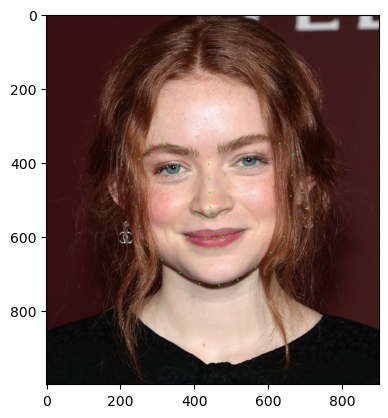

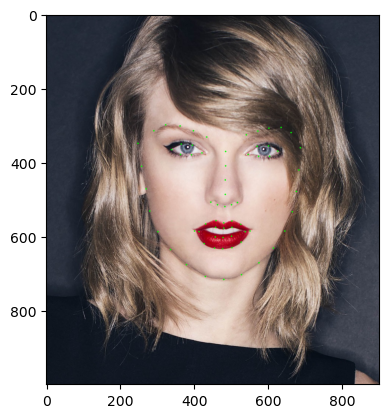

In [4]:
face1 = cv2.imread('./pics/initial.jpg');
face2 = cv2.imread('./pics/final.jpg');
(shape1,img1) = findFeatures(face1);
(shape2,img2) = findFeatures(face2);
cv2.imwrite('./pics/initial_points.png',img1);
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('./pics/final_points.png',img2);
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

## Part 2 - Mesh:

In [5]:
#we add points in the corners and middle of the sides:
shape1 = np.vstack((shape1,[0,0]));
shape1 = np.vstack((shape1,[0,499]));
shape1 = np.vstack((shape1,[0,999]));
shape1 = np.vstack((shape1,[899,0]));
shape1 = np.vstack((shape1,[900,499]));
shape1 = np.vstack((shape1,[899,999]));
shape1 = np.vstack((shape1,[449,1000]));
shape1 = np.vstack((shape1,[449,0]));

shape2 = np.vstack((shape2,[0,0]));
shape2 = np.vstack((shape2,[0,499]));
shape2 = np.vstack((shape2,[0,999]));
shape2 = np.vstack((shape2,[899,0]));
shape2 = np.vstack((shape2,[900,499]));
shape2 = np.vstack((shape2,[899,999]));
shape2 = np.vstack((shape2,[449,1000]));
shape2 = np.vstack((shape2,[449,0]));

In [6]:
def DelaunayTriangulation(points,width=900,height=1000):
    tri = Delaunay(points);
    return tri;

In [7]:
def showDelaunayTriangulation(points,image,filename,width=900,height=1000):
    triangles = DelaunayTriangulation(points);
    plt.triplot(points[:,0], points[:,1], triangles.simplices)
    plt.plot(points[:,0], points[:,1], 'o')
    plt.imshow(image,alpha = 0.5);
    plt.savefig(filename)
    plt.show()
    return triangles;

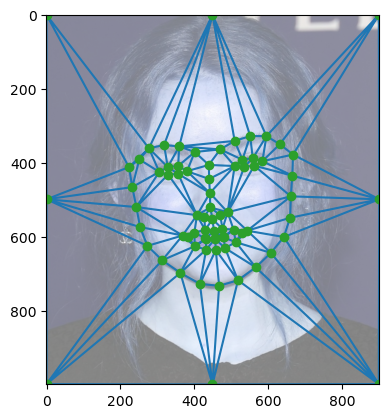

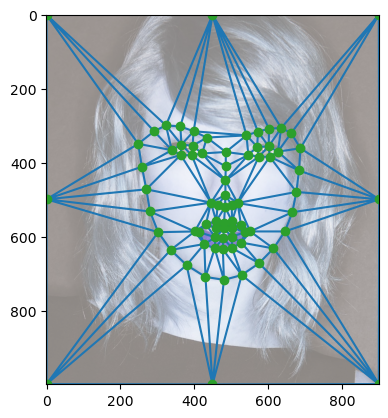

In [8]:
showDelaunayTriangulation(shape1,face1,"./pics/initialTriangularization.jpg");
showDelaunayTriangulation(shape2,face2,"./pics/finalTriangularization.jpg");

## Part 3 - Blending with a mesh:

In [9]:
def point_in_triangle(point, triangle):
    # get the coordinates of the point
    x, y = point
    ax, ay = triangle[0]
    bx, by = triangle[1]
    cx, cy = triangle[2]
    # Find on which half-plane the point is with respect to the three sides of the triangle
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)


In [10]:
def Mesh(image1,shape1,image2,shape2,w=0.5,width=900,heigth=1000):
    midpoints = shape1*(1-w)+shape2*w;
    triangularization = DelaunayTriangulation(midpoints);
    mesh = image1.copy();
    k=1;
    for index,triangle in enumerate(triangularization.simplices):
        #for each triangle in the Delaunay Triangulation of the intermediate image we are currently working on
        #we calculate the transform matrix that takes the corresponding points in the initial image to the intermediate image
        #and the transform matrix that takes the corresponding points in the final image to the intermediate image
        B=[[midpoints[triangle[0],1],midpoints[triangle[1],1],midpoints[triangle[2],1]],[midpoints[triangle[0],0],midpoints[triangle[1],0],midpoints[triangle[2],0]],[1,1,1]];
        C1=np.linalg.inv([[shape1[triangle[0],1],shape1[triangle[1],1],shape1[triangle[2],1]],[shape1[triangle[0],0],shape1[triangle[1],0],shape1[triangle[2],0]],[1,1,1]])
        A1=np.dot(B,C1);
        T1=np.linalg.inv(A1);
        C2=np.linalg.inv([[shape2[triangle[0],1],shape2[triangle[1],1],shape2[triangle[2],1]],[shape2[triangle[0],0],shape2[triangle[1],0],shape2[triangle[2],0]],[1,1,1]])
        A2=np.dot(B,C2);
        T2=np.linalg.inv(A2);
        minh = math.floor(min(midpoints[triangle[0],1],midpoints[triangle[1],1],midpoints[triangle[2],1]));
        maxh = math.ceil(max(midpoints[triangle[0],1],midpoints[triangle[1],1],midpoints[triangle[2],1]));
        minw = math.floor(min(midpoints[triangle[0],0],midpoints[triangle[1],0],midpoints[triangle[2],0]));
        maxw = math.ceil(max(midpoints[triangle[0],0],midpoints[triangle[1],0],midpoints[triangle[2],0]));
        #we search for the points in the intermediate image that are inside the current triangle
        for j in range(minh,min(maxh+1,1000)):
            for i in range(minw,min(maxw+1,900)):
                if(point_in_triangle((i,j),[(midpoints[triangle[0],0],midpoints[triangle[0],1]),(midpoints[triangle[1],0],midpoints[triangle[1],1]),(midpoints[triangle[2],0],midpoints[triangle[2],1])])):
                    [[j1],[i1],[k1]] = np.dot(T1,[[j],[i],[1]]);
                    [[j2],[i2],[k2]] = np.dot(T2,[[j],[i],[1]]);
                    #we calculate the corresponding points in the initial and final image and interpolate them from the lattice
                    #points that correspond to pixels
                    p1 = (i1-math.floor(i1))*(j1-math.floor(j1))*image1[min(math.floor(j1),999),min(math.floor(i1),899)]+(i1-math.floor(i1))*(1+math.floor(j1)-j1)*image1[min(math.floor(j1)+1,999),min(math.floor(i1),899)]+(1+math.floor(i1)-i1)*(j1-math.floor(j1))*image1[min(math.floor(j1),999),min(math.floor(i1)+1,899)]+(1+math.floor(i1)-i1)*(1+math.floor(j1)-j1)*image1[min(math.floor(j1)+1,999),min(math.floor(i1)+1,899)];
                    p2 = (i2-math.floor(i2))*(j2-math.floor(j2))*image2[min(math.floor(j2),999),min(math.floor(i2),899)]+(i2-math.floor(i2))*(1+math.floor(j2)-j2)*image2[min(math.floor(j2)+1,999),min(math.floor(i2),899)]+(1+math.floor(i2)-i2)*(j2-math.floor(j2))*image2[min(math.floor(j2),999),min(math.floor(i2)+1,899)]+(1+math.floor(i2)-i2)*(1+math.floor(j2)-j2)*image2[min(math.floor(j2)+1,999),min(math.floor(i2)+1,899)];
                    mesh[j,i,0]=(int)(p1[0]*(1-w)+p2[0]*w);
                    mesh[j,i,1]=(int)(p1[1]*(1-w)+p2[1]*w);
                    mesh[j,i,2]=(int)(p1[2]*(1-w)+p2[2]*w);
    return mesh;

In [11]:
#we find the mid image in our transformation
median_img = Mesh(face1,shape1,face2,shape2);
cv2.imwrite('./pics/median.png',median_img);

## Part 4 - Blending without a mesh:

In [12]:
def Blend_vf(initial,initial_shape,final,final_shape,w=0.5):
    initial_shape = (1-w)*initial_shape+w*final_shape
    difference=initial_shape-final_shape;
    n,m = difference.shape;
    sizeX,sizeY,sizeZ = initial.shape;
    def_vect_field = np.zeros((sizeX,sizeY,2));
    for i in range(sizeX):
        for j in range(sizeY):
            denominator = 0.0;
            nominator = [0.0,0.0];
            important_point = 0;
            for k in range(n):
                if(i == initial_shape[k,1] and j == initial_shape[k,0]):
                    important_point = 1;
                    def_vect_field[i,j]=[difference[k,1],difference[k,0]];
                    k=n;
                else:    
                    deformation = np.linalg.norm((np.array([i,j])-np.array([initial_shape[k,1],initial_shape[k,0]])),2)
                    weighted_deformation = 1/(0.05*deformation*deformation);
                    denominator = denominator+weighted_deformation;
                    nominator = nominator+weighted_deformation*np.array([difference[k,1],difference[k,0]]);
            if(important_point == 0):
                def_vect_field[i,j]=nominator/denominator;
    return def_vect_field;        

In [13]:
vect_field = Blend_vf(face1,shape1,face2,shape2);

In [14]:
def Blend(initial,initial_shape,final,final_shape,def_vect_field,w=0.5):
    midface = np.zeros((1000,900,3));
    for i in range(1000):
        for j in range(900):
            midface[i,j] = (1-w)*face1[i,j] + w*face2[min(999,i-math.floor(def_vect_field[i,j,0])),min(899,j-math.floor(def_vect_field[i,j,1]))];
    return midface

In [15]:
midface = Blend(face1,shape1,face2,shape2,vect_field)

In [16]:
cv2.imwrite('./pics/median_meshless.png',midface);

## Part 5 - Video:

In [21]:
for t in tqdm(range(51)):
    w = t/50;
    mesh = Mesh(face1,shape1,face2,shape2,w);
    cv2.imwrite(f'./pics/video/img{t}.png',mesh);

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [38:22<00:00, 45.14s/it]


In [22]:
img_array = [];
for nr in tqdm(range(51)):
    file = f'./pics/video/img{nr}.png'
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./pics/video/transformation_mesh.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 16.42it/s]


In [23]:
for t in tqdm(range(51)):
    w = t/50;
    vect_field = Blend_vf(face1,shape1,face2,shape2,w);
    b = Blend(face1,shape1,face2,shape2,vect_field,w);
    cv2.imwrite(f'./pics/video/img{t}_meshless.png',b);

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [6:46:41<00:00, 478.47s/it]


In [24]:
img_array = [];
for nr in tqdm(range(51)):
    file = f'./pics/video/img{nr}_meshless.png'
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./pics/video/transformation_meshless.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 18.77it/s]
